In [62]:
import math

import numpy as np
from numpy import array, dot

import matplotlib.pyplot as plt

import cvxopt
from cvxopt import matrix

# CVXOPT wrapper
# Credit: https://scaron.info/blog/quadratic-programming-in-python.html

# solves:
#   minimize    0.5 x^t P x + q^t x
#   subject to  G x <= h
#               A x = b

def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P = P.astype(float)
    q = q.astype(float)
    P = .5 * (P + P.T)  # make sure P is symmetric
    args = [matrix(P), matrix(q)]
    if G is not None:
        G = G.astype(float)
        h = h.astype(float)
        args.extend([matrix(G), matrix(h)])
        if A is not None:
            A = A.astype(float)
            b = b.astype(float)
            args.extend([matrix(A), matrix(b)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return array(sol['x']).reshape((P.shape[1],))

In [139]:
# CVXOPT test
M = array([[1., 2., 0.], [-8., 3., 2.], [0., 1., 1.]])
P = dot(M.T, M)
q = -dot(M.T, array([3., 2., 3.]))
G = array([[1., 2., 1.], [2., 0., 1.], [-1., 2., -1.]])
h = array([3., 2., -2.]).reshape((3,))

arr = cvxopt_solve_qp(P, q, G, h)

EPS = 1e-3
assert math.isclose(arr[0], 0.12997347, rel_tol=EPS)
assert math.isclose(arr[1], -0.06498674, rel_tol=EPS)
assert math.isclose(arr[2], 1.74005305, rel_tol=EPS)

print("Solution is correct.")

     pcost       dcost       gap    pres   dres
 0: -1.0062e+01 -8.2131e+00  3e+00  8e-01  2e-16
 1: -8.9877e+00 -7.1656e+00  6e-01  3e-01  2e-16
 2: -4.7428e+00 -5.6786e+00  9e-01  9e-17  5e-16
 3: -5.5832e+00 -5.5940e+00  1e-02  5e-17  1e-16
 4: -5.5921e+00 -5.5922e+00  1e-04  8e-17  2e-16
 5: -5.5922e+00 -5.5922e+00  1e-06  9e-17  2e-16
Optimal solution found.
Solution is correct.


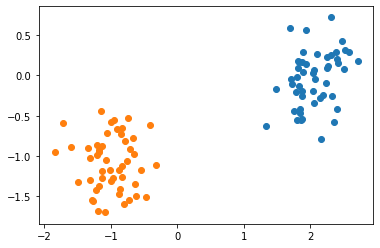

In [160]:
# SAMPLING

# Class 1
N_1 = 50
MU_1 = [2.0, -0.1]
SIGMA_1 = [[0.1, 0.0],
           [0.0, 0.1]]
X_1 = np.random.multivariate_normal(MU_1, SIGMA_1, N_1)

# Class 2
N_2 = 50
MU_2 = [-1.0, -1.0]
SIGMA_2 = [[0.1, 0.0],
           [0.0, 0.1]]
X_2 = np.random.multivariate_normal(MU_2, SIGMA_2, N_2)

# Unify
X = np.vstack( (X_1, X_2) )
Y = np.array([1] * N_1 + [-1] * N_2)
N = len(X)

# Plot
plt.scatter(X_1[:,0], X_1[:,1])
plt.scatter(X_2[:,0], X_2[:,1])
plt.show()

In [161]:
# SVM
# https://youtu.be/eHsErlPJWUU?t=2583

#   minimize    0.5 x^t P x + q^t x
#   subject to  G x <= h
#               A x = b

P = np.zeros( (N, N) )
for i in range(N):
    for j in range(N):
        P[i,j] = Y[i] * Y[j] * np.dot(X[i], X[j])

q = np.full(N, -1.)

A = Y.copy().reshape( (1, 100) )
b = np.zeros( (1, 1) )

G = -np.eye(N)
h = np.zeros(N)

h.shape

alpha = cvxopt_solve_qp(P, q, G, h, A, b)
#matrix(A.astype(float))

     pcost       dcost       gap    pres   dres
 0: -3.9196e+00 -6.4641e+00  2e+02  1e+01  2e+00
 1: -1.0805e+00 -1.4041e+00  1e+01  7e-01  7e-02
 2: -1.9658e-01 -1.0458e+00  8e-01  3e-16  8e-16
 3: -4.9425e-01 -6.9550e-01  2e-01  3e-16  6e-16
 4: -6.5032e-01 -6.8948e-01  4e-02  1e-16  4e-16
 5: -6.8220e-01 -6.8266e-01  5e-04  8e-17  5e-16
 6: -6.8257e-01 -6.8258e-01  5e-06  2e-16  5e-16
 7: -6.8258e-01 -6.8258e-01  5e-08  3e-16  5e-16
Optimal solution found.


In [162]:
# Get 
w = np.zeros(2)
for i in range(N):
    w += alpha[i] * Y[i] * X[i]

support_vectors_idx = np.argwhere(alpha > 1e-3).ravel()

sv_idx = support_vectors_idx[0]
b = Y[sv_idx] - np.dot(w.T, X[sv_idx])

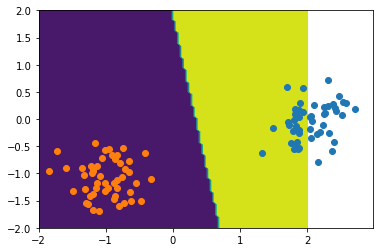

In [163]:
# Plot
# https://stackoverflow.com/questions/19054923/plot-decision-boundary-matplotlib

nx = 100
ny = 100

xx, yy = np.meshgrid(np.linspace(-2, 2, nx), np.linspace(-2, 2, ny))

Z = np.empty(xx.shape)
for iy in range(ny):
    for ix in range(nx):
        x = xx[iy, ix]
        y = yy[iy, ix]
        decision_func = x * w[0] + y * w[1] + b
        Z[iy, ix] = 2 if decision_func >= 0 else 1

plt.contourf(xx, yy, Z)
plt.scatter(X_1[:,0], X_1[:,1])
plt.scatter(X_2[:,0], X_2[:,1])
plt.show()